In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics as skm
import h5py
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline
tf.random.set_seed(42)

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Dataset_thesis/mhealth_raw_data.csv')
df



,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,0,subject1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,1.7849,-9.8287,0.29725,-0.341370,-0.90056,-0.61493,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,0,subject10
1215741,1.8687,-9.8766,0.46236,-0.341370,-0.90056,-0.61493,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,0,subject10
1215742,1.6928,-9.9290,0.16631,-0.341370,-0.90056,-0.61493,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,0,subject10
1215743,1.5279,-9.6306,0.30458,-0.341370,-0.90056,-0.61493,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0,subject10


In [ ]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [ ]:
#Dropping feature have data outside 98% confidence interval
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)


alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [ ]:
label_map_mHealth = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

label_map_oppo={
    0: 'Open Door 1',
    1: 'Open Door 2',  
    2: 'Close Door 1', 
    3: 'Close Door 2',  
    4: 'Open Fridge',  
    5: 'Close Fridge',  
    6: 'Open Dishwasher',
    7: 'Close Dishwasher', 
    8: 'Open Drawer 1', 
    9: 'Close Drawer 1', 
    10: 'Open Drawer 2', 
    11: 'Close Drawer 2', 
    12: 'Open Drawer 3',
    13: 'Close Drawer 3',
    14: 'Clean Table',
    15: 'Drink from Cup',
    16: 'Toggle Switch'
}

In [ ]:
#spliting data into 70% for train and 30% for test set
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((246501, 14), (64428, 14))

In [ ]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [ ]:
from scipy import stats

#function to create time series datset for sequence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train_mHealth,y_train_mHealth = create_dataset(X_train, y_train, 100, step=50)
X_train_mHealth.shape, y_train_mHealth.shape


((4929, 100, 12), (4929, 1))

In [ ]:
X_test_mHealth,y_test_mHealth = create_dataset(X_test, y_test, 100, step=50)
X_test_mHealth.shape, y_test_mHealth.shape

((1287, 100, 12), (1287, 1))

In [ ]:
path ='/content/drive/MyDrive/Dataset_thesis/ML_Both_Arms (1).h5'

In [ ]:
f = h5py.File(path, 'r')
X = f.get('inputs')
y = f.get('labels') 
X_oppo = np.array(X)
y_oppo = np.array(y)

In [ ]:
X_train_oppo, X_test_oppo, y_train_oppo, y_test_oppo=train_test_split(X_oppo, y_oppo, test_size=0.3, random_state = 1)

In [ ]:
X_train_oppo.shape, X_test_oppo.shape

((7432, 32, 230), (3186, 32, 230))

In [ ]:
def cnnLstm(input_shape,n_outputs):
  model = keras.Sequential()
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool1D(2))
  model.add(layers.LSTM(64))
  model.add(layers.Dense(units=128, activation='relu'))
  model.add(layers.Dense(n_outputs, activation='softmax'))
  model.summary()
  return model


In [ ]:
def compile(dataset,X_train,y_train,X_test,y_test,epochs):
  trainy_one_hot = to_categorical(y_train)
  input_shape=[X_train.shape[1],X_train.shape[2]]
  n_outputs=trainy_one_hot.shape[1]

  model=cnnLstm(input_shape,n_outputs)
  
  if not os.path.isdir('/content/drive/MyDrive/best_models'):
    os.mkdir('/content/drive/MyDrive/best_models')
  callbacks = [keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_models/'+dataset+"_best.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy")]
  
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
  
  model_history = model.fit(X_train,y_train, epochs= epochs, validation_data=(X_test,y_test), callbacks=callbacks)
  return model,model_history

In [ ]:
cnnLSTM_oppo,modelHistory_oppo=compile('Opportunity',X_train_oppo,y_train_oppo,X_test_oppo,y_test_oppo,100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 32, 32)            22112     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32)           128       
 hNormalization)                                                 
                                                                 
 re_lu_8 (ReLU)              (None, 32, 32)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 32, 64)            6208      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 64)           256       
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 32, 64)           

In [ ]:
cnnLSTM_mHealth,modelHistory_mHealth=compile('MHEALTH',X_train_mHealth,y_train_mHealth,X_test_mHealth,y_test_mHealth,30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           1184      
                                                                 
 batch_normalization (BatchN  (None, 100, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 100, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 100, 64)           0

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/history'):
  os.mkdir('/content/drive/MyDrive/history')

In [ ]:
def save_history(modelhistory,dataset):
    with open('/content/drive/MyDrive/history/modelHistory_'+dataset+'.h5','wb') as f:
      pickle.dump(modelhistory.history,f)


In [ ]:
#save_history(modelHistory_oppo,'Opportunity')
save_history(modelHistory_mHealth,'MHEALTH')

In [ ]:
def history_plot(dataset):
  with open('/content/drive/MyDrive/history/modelHistory_'+dataset+'.h5','rb') as f:
    history=pickle.load(f)
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_accuracy = history['sparse_categorical_accuracy']
  val_accuracy = history['val_sparse_categorical_accuracy']

  plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(train_loss, 'r', label='Training loss')
  plt.plot(val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation Loss on '+dataset+' dataset')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(train_accuracy, 'r', label='Training Accuracy')
  plt.plot(val_accuracy, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy on '+dataset+' dataset')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()


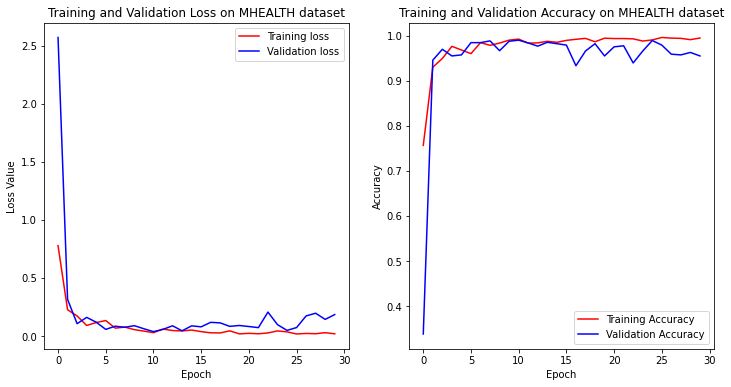

In [ ]:
#history_plot('Opportunity')
history_plot('MHEALTH')

In [ ]:
def testing_model(dataset,X_train,X_test,y_train,y_test,label_map):

  model = keras.models.load_model('/content/drive/MyDrive/best_models/' + dataset + '_best.h5')

  train_loss, train_acc = model.evaluate(X_train,y_train)
  test_loss, test_acc = model.evaluate(X_test,y_test)

  print("Train accuracy", round(train_acc*100, 2),'%')
  print("Train loss", train_loss)
  print("Test accuracy", round(test_acc*100, 2),'%')
  print("Test loss", test_loss)

  pred = model.predict(X_test)
  pred = np.argmax(pred, axis = 1)
  pred = pred.reshape(-1,1)

  from sklearn.metrics import confusion_matrix, classification_report
 
  print(classification_report(y_test,pred))
  print('*'*50)
  print(confusion_matrix(y_test,pred))

  print('Precision: %.3f' % skm.precision_score(y_test, pred, average='weighted'))
  print('Recall: %.3f' % skm.recall_score(y_test, pred, average='weighted'))
  print('F1 Score: %.3f' % skm.f1_score(y_test, pred, average='weighted'))
  
  #####plotting confusion matri#####################
  conf_matrix = confusion_matrix(y_test,pred)
  N=len(label_map)

  cf=np.empty((N,N))
  for i in range(N):
    cf[i]=(conf_matrix[i]/np.sum(conf_matrix[i]))

  group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
  labels = [f"{v1}" for v1 in group_percentages]
  labels = np.asarray(labels).reshape(N,N)

  fig = plt.figure(figsize=(16,12))
  ax=fig.add_subplot(111)
  sns.heatmap(conf_matrix, xticklabels=label_map.values(), yticklabels=label_map.values(), annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
  ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(skm.accuracy_score(y_test,pred)))
  ax.set_ylabel("True Labels")
  ax.set_title("Confusion Matrix")


100/100 [==============================] - 1s 9ms/step - loss: 0.2337 - sparse_categorical_accuracy: 0.9520
Train accuracy 99.99 %
Train loss 0.0014942684210836887
Test accuracy 95.2 %
Test loss 0.23368993401527405
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       185
           1       0.94      0.98      0.96       199
           2       0.96      0.96      0.96       201
           3       0.97      0.92      0.94       190
           4       0.89      0.96      0.93       219
           5       0.97      0.91      0.94       202
           6       0.89      0.90      0.89       158
           7       0.90      0.85      0.88       124
           8       0.88      0.93      0.90        96
           9       0.89      0.88      0.88        56
          10       1.00      0.90      0.95        81
          11       0.97      0.94      0.95        62
          12       0.93      0.88      0.90       104
          13       0.82     

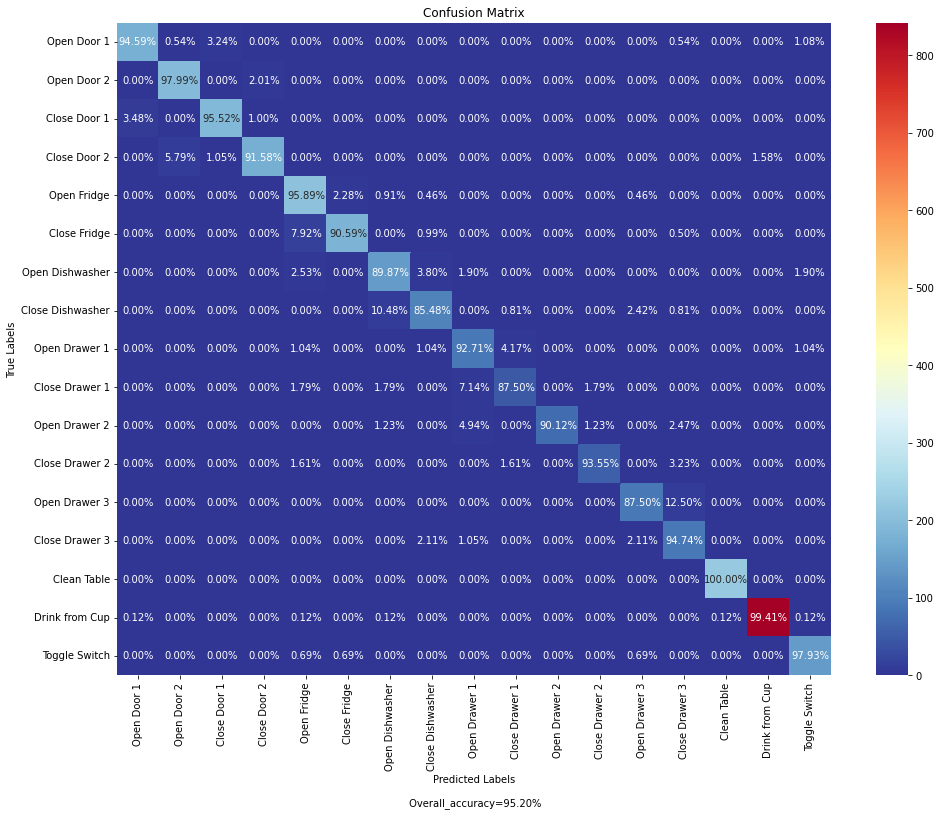

In [ ]:
testing_model('Opportunity',X_train_oppo,X_test_oppo,y_train_oppo,y_test_oppo,label_map_oppo)

41/41 [==============================] - 0s 12ms/step - loss: 0.0376 - sparse_categorical_accuracy: 0.9899
Train accuracy 99.76 %
Train loss 0.010390281677246094
Test accuracy 98.99 %
Test loss 0.03759663924574852
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      0.99      1.00       123
           2       0.98      1.00      0.99       123
           3       0.99      0.99      0.99       122
           4       1.00      0.99      1.00       120
           5       0.94      0.98      0.96        84
           6       1.00      0.99      1.00       106
           7       1.00      1.00      1.00       112
           8       0.98      0.96      0.97       116
           9       1.00      0.99      1.00       121
          10       0.98      1.00      0.99        89
          11       1.00      0.98      0.99        52
          12       1.00      1.00      1.00        27

    accuracy                

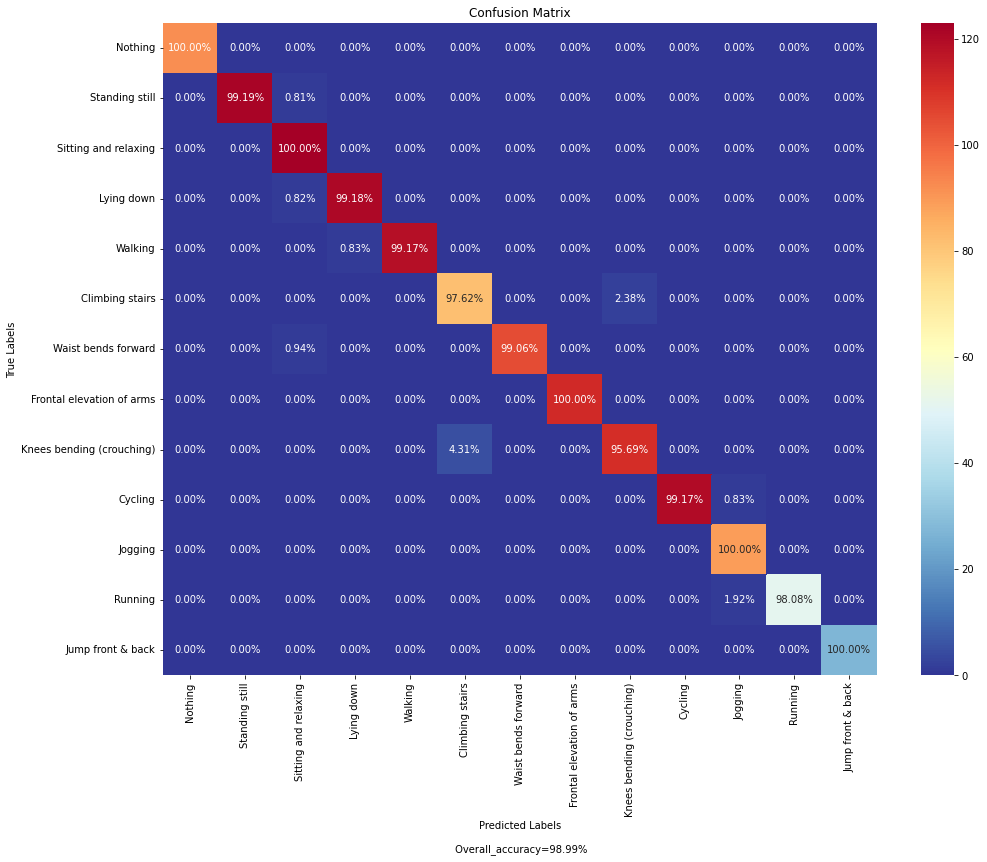

In [ ]:
testing_model('MHEALTH',X_train_mHealth,X_test_mHealth,y_train_mHealth,y_test_mHealth,label_map_mHealth)

Precison,recall,f1_score activity wise

In [38]:
def activity_wise_metrcis(n_classes,dataset,X_test,y_test,label_map):
  metrics=np.empty((0,n_classes+1))
  
  model = keras.models.load_model('/content/drive/MyDrive/best_models/' + dataset + '_best.h5')
  predy = model.predict(X_test)
  predy = np.argmax(predy, axis = 1)
  predy = predy.reshape(-1,1)

  precision=skm.precision_score(y_test, predy, average=None)
  precision_avg=skm.precision_score(y_test, predy,average='weighted')
  precision=np.hstack([precision,precision_avg])
  metrics=np.vstack([metrics,precision])

  recall=skm.recall_score(y_test, predy, average=None)
  recall_avg=skm.recall_score(y_test, predy, average='weighted')
  recall=np.hstack([recall,recall_avg])
  metrics=np.vstack([metrics,recall])

  f1=skm.f1_score(y_test, predy, average=None)
  f1_avg=skm.f1_score(y_test, predy,average='weighted')
  f1=np.hstack([f1,f1_avg])
  metrics=np.vstack([metrics,f1])

  matrix=skm.confusion_matrix(y_test,predy)
  acc=matrix.diagonal()/matrix.sum(axis=1)
  acc_avg=skm.accuracy_score(y_test,predy)
  acc=np.hstack([acc,acc_avg])
  metrics=np.vstack([metrics,acc])

  df_metrics=pd.DataFrame(metrics)
  col=list(label_map.values())
  col.append('avg')
  df_metrics.columns=col
  df_metrics.index=['precsion','recall','f1_score','accuracy']

  if not os.path.isdir('/content/drive/MyDrive/metrics'):
    os.mkdir('/content/drive/MyDrive/metrics')
  df_metrics.to_csv('/content/drive/MyDrive/metrics/Activitywise_metrics_for_'+dataset+'.csv')



In [39]:
activity_wise_metrcis(13,'MHEALTH',X_test_mHealth,y_test_mHealth,label_map_mHealth)

In [40]:
activity_wise_metrcis(17,'Opportunity',X_test_oppo,y_test_oppo,label_map_oppo)